In [1]:
# Third-party
from astropy.io import ascii
from astropy.table import Table, join, vstack
import astropy.coordinates as coord
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from pyia import GaiaData

In [4]:
mgiants = Table.read('../../low-latitude-structures/data/mgiants-only.csv', format='ascii.csv')
mgiants.remove_column('ra')
mgiants.remove_column('dec')

In [5]:
xmatch = Table.read('../../low-latitude-structures/data/mgiants-gaiadr2.fits')
xmatch.rename_column('id', 'ID')
xmatch.rename_column('dist', 'angdist')

In [6]:
tbl = join(mgiants, xmatch, keys='ID')
tbl = tbl[tbl['structure'] == 'TriAnd']

In [7]:
c = coord.SkyCoord(ra=tbl['ra'], dec=tbl['dec'])
fk5 = c.transform_to(coord.FK5)

In [8]:
ta1 = ascii.read('../../low-latitude-structures/data/TA1_CaT.txt')
ta2 = ascii.read('../../low-latitude-structures/data/TA2_CaT.txt')
ta_cat = vstack((ta1, ta2))

In [9]:
ta_cat_ra = []
ta_cat_dec = []
for row in ta_cat:
    _ra = row['2MASSID'][:7]
    _dec = row['2MASSID'][7:]
    ra = coord.Longitude(':'.join([_ra[:2], _ra[2:4], '.'.join([_ra[4:6], _ra[6]])]), 
                         unit=u.hourangle)
    dec = coord.Latitude(':'.join([_dec[:3], _dec[3:5], _dec[5:]]),
                         unit=u.degree)
    ta_cat_ra.append(ra)
    ta_cat_dec.append(dec)
    
    # print(_ra, ra, _ra[4:])
    # print(_dec, dec, _dec[5:])
    # print()
    
ta_cat_ra = coord.Longitude(ta_cat_ra)
ta_cat_dec = coord.Latitude(ta_cat_dec)
ta_cat_c = coord.SkyCoord(ra=ta_cat_ra, dec=ta_cat_dec)

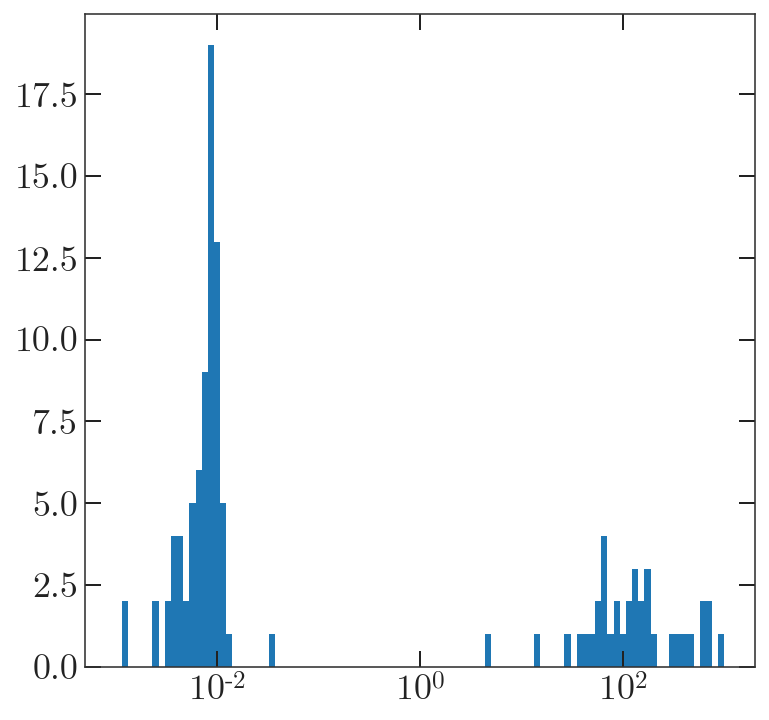

In [10]:
idx, sep, _ = fk5.match_to_catalog_sky(ta_cat_c)
plt.hist(sep.arcmin, bins=np.logspace(-3, 3, 100));
plt.xscale('log')

feh = np.full(len(c), np.nan)
feh[sep < 1*u.arcmin] = ta_cat['[Fe/H]'][idx[sep < 1*u.arcmin]]

dist = np.full(len(c), np.nan)
dist[sep < 1*u.arcmin] = ta_cat['dist'][idx[sep < 1*u.arcmin]]
dist_err = 0.15 * dist

tbl['feh'] = feh
tbl['dist'] = dist * u.kpc
tbl['dist_err'] = dist_err * u.kpc

In [11]:
# # My attempt to compute distance using relation from Sheffield et al.
# M_K = (3.8 + 1.3*feh) - 8.4*(tbl['J-Ks'])
# apw_dist = coord.Distance(distmod=tbl['Ks'] - M_K).to(u.kpc)
# apw_dist_err = 0.15 * dist

In [12]:
g = GaiaData(tbl[np.isfinite(tbl['dist'])])

In [13]:
all_c = g.get_skycoord(distance=g.dist, 
                       radial_velocity=g.v_hel*u.km/u.s)
gal_c = all_c.transform_to(coord.Galactocentric(galcen_distance=8*u.kpc))

In [14]:
cyl = gal_c.represent_as('cylindrical')

In [15]:
vR = cyl.differentials['s'].d_rho.to(u.km/u.s)
vphi = (cyl.rho * cyl.differentials['s'].d_phi).to(u.km/u.s, u.dimensionless_angles())
vz = cyl.differentials['s'].d_z.to(u.km/u.s)

Text(0.5,0,'$v_{\\rm tot}$')

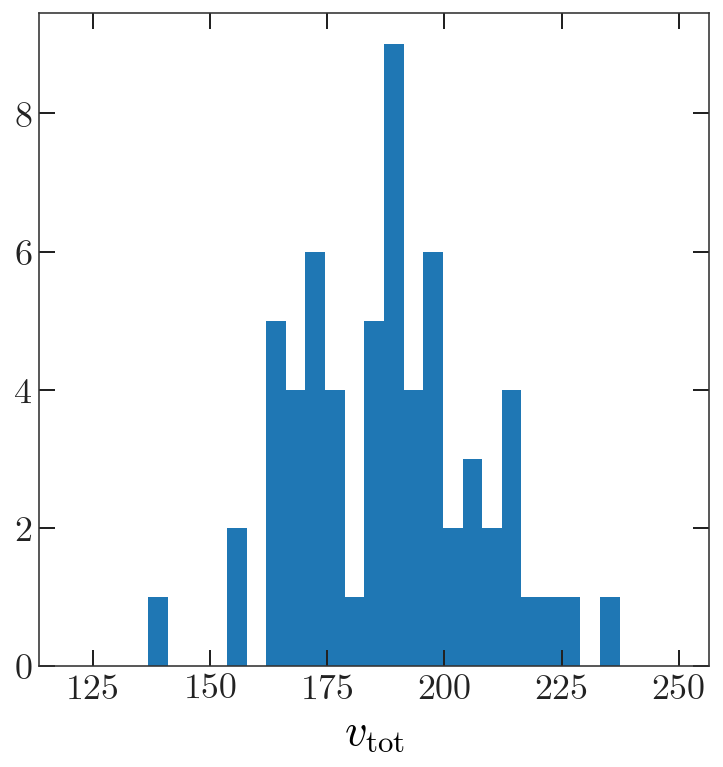

In [20]:
plt.hist(gal_c.transform_to(coord.Galactocentric).velocity.norm().value, bins=np.linspace(120, 250, 32));
plt.xlabel(r'$v_{\rm tot}$')

(-350, 350)

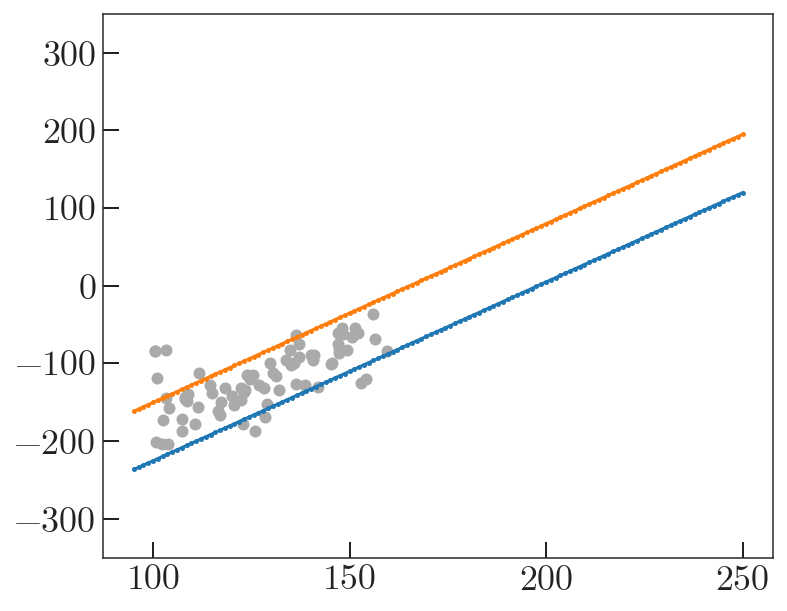

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

ax.scatter(all_c.galactic.l.degree, 
           all_c.radial_velocity, color='#aaaaaa')
# ax.scatter(all_c.galactic.l.degree[mask], 
#            all_c.radial_velocity[mask], 
#            color='k')bb

l = np.linspace(95, 250, 128)

ax.plot(l, 2.3*(l-150) - 110)
ax.plot(l, 2.3*(l-150) - 35)

ax.set_ylim(-350, 350)

In [17]:
nsamples = 1024

dist_samples = np.random.normal(g.dist, g.dist_err, 
                                size=(nsamples, len(g))).T * u.kpc

pm = np.vstack((g.pmra.value, g.pmdec.value)).T
pmcov = g.get_cov()[:, 3:5, 3:5]
pm_samples = np.array([np.random.multivariate_normal(pm[i], pmcov[i], size=nsamples) 
                       for i in range(len(pm))]) * g.pmra.unit

rv_samples = np.random.normal(g.v_hel, g.v_err, size=(nsamples, len(g))).T * u.km/u.s

c_samples = coord.SkyCoord(ra=g.ra[:, None],
                           dec=g.dec[:, None],
                           distance=dist_samples,
                           pm_ra_cosdec=pm_samples[...,0],
                           pm_dec=pm_samples[...,1],
                           radial_velocity=rv_samples)

gal_c_samples = c_samples.transform_to(coord.Galactocentric(galcen_distance=8*u.kpc))

In [18]:
cyl_samples = gal_c_samples.represent_as('cylindrical')

vR_samples = cyl_samples.differentials['s'].d_rho.to(u.km/u.s)
vphi_samples = (cyl_samples.rho * cyl_samples.differentials['s'].d_phi).to(u.km/u.s, u.dimensionless_angles())
vz_samples = cyl_samples.differentials['s'].d_z.to(u.km/u.s)

vcyl = np.stack((vR_samples.value,
                 vphi_samples.value,
                 vz_samples.value))

med_vcyl = np.median(vcyl, axis=-1)
std_vcyl = 1.5 * np.median(np.abs(vcyl - med_vcyl[..., None]), axis=-1)
med_vtot = np.sqrt(np.sum(med_vcyl**2, axis=0))
vtot_mask = (med_vtot > 100) & (med_vtot < 320)

In [19]:
med_xyz = np.median(gal_c_samples.cartesian.xyz, axis=-1)
std_xyz = 1.5 * np.median(np.abs(gal_c_samples.cartesian.xyz - med_xyz[..., None]), axis=-1).value
med_xyz = med_xyz.value

In [20]:
cyl_pos = np.stack((cyl_samples.rho.to(u.kpc).value,
                    cyl_samples.phi.to(u.deg).value,
                    cyl_samples.z.to(u.kpc).value))
med_cyl = np.median(cyl_pos, axis=-1)
std_cyl = 1.5 * np.median(np.abs(cyl_pos - med_cyl[..., None]), axis=-1)

In [21]:
style = dict(marker='o', ls='none', color='k',
             ecolor='#aaaaaa', alpha=0.6)

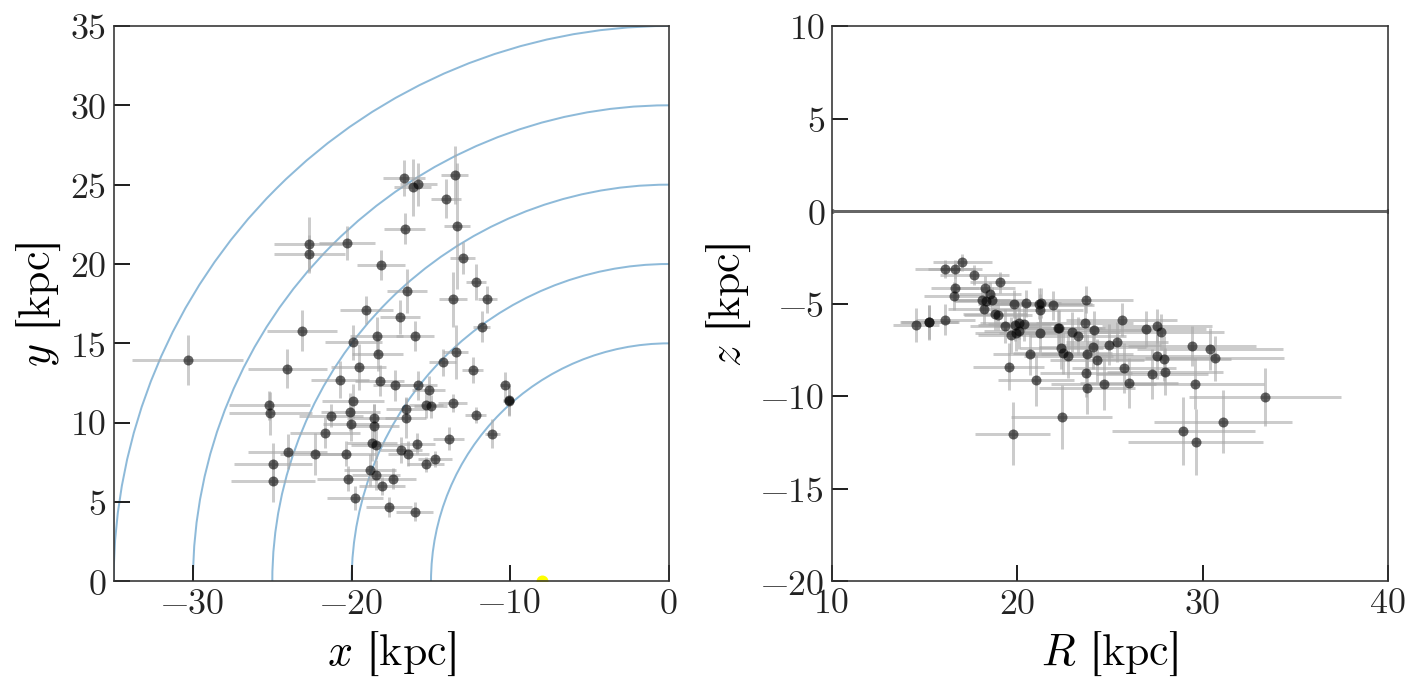

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

ax = axes[0]
ax.errorbar(med_xyz[0], med_xyz[1],
            xerr=std_xyz[0], yerr=std_xyz[2],
            **style)

ax.scatter(-8, 0, marker='o', color='yellow')

ax.set_xlim(-35, 0)
ax.set_ylim(0, 35)

for R in np.arange(15, 35+1, 5):
    pa = mpl.patches.Circle((0,0), radius=R, 
                            facecolor='none', edgecolor='tab:blue', alpha=0.5)
    ax.add_patch(pa)

ax.set_xlabel('$x$ [kpc]')
ax.set_ylabel('$y$ [kpc]')
    
# ---

ax = axes[1]
ax.errorbar(med_cyl[0], med_cyl[2],
            xerr=std_cyl[0], yerr=std_cyl[2],
            **style)

ax.axhline(0)

ax.set_xlim(10, 40)
ax.set_ylim(-20, 10)

ax.set_xlabel('$R$ [kpc]')
ax.set_ylabel('$z$ [kpc]')


for ax in axes:
    ax.set_aspect('equal')
    
fig.tight_layout()

fig.savefig('../plots/xy_Rz.png', dpi=250)

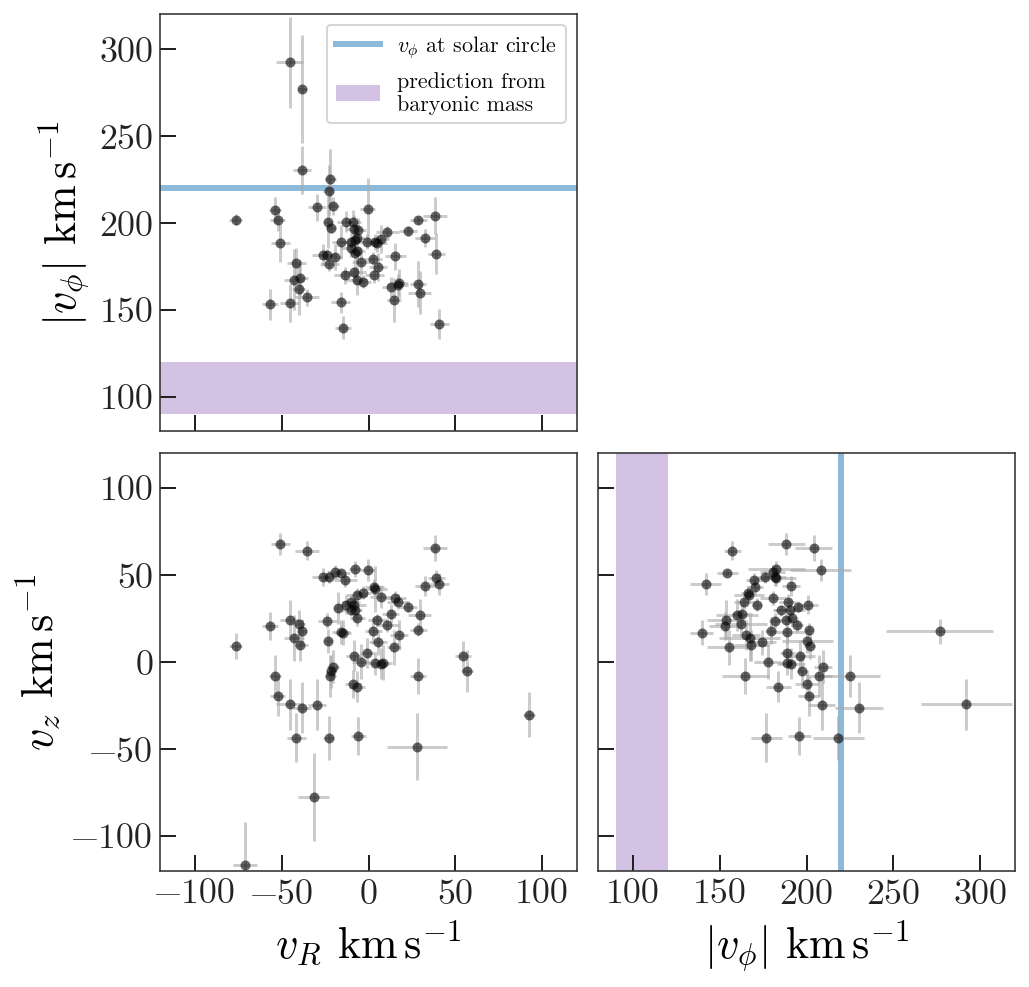

In [237]:
fig, axes = plt.subplots(2, 2, figsize=(7.3, 7), 
                         sharex='col', sharey='row')

axes[0, 0].errorbar(med_vcyl[0], 
                    np.abs(med_vcyl[1]),
                    xerr=std_vcyl[0],
                    yerr=std_vcyl[1],
                    **style)

axes[1, 0].errorbar(med_vcyl[0], 
                    med_vcyl[2],
                    xerr=std_vcyl[0],
                    yerr=std_vcyl[2],
                    **style)

axes[1, 1].errorbar(np.abs(med_vcyl[1]), 
                    med_vcyl[2], 
                    xerr=std_vcyl[1],
                    yerr=std_vcyl[2],
                    **style)

axes[1, 1].set_xlim(80, 320)
axes[1, 1].set_ylim(-120, 120)
axes[0, 0].set_xlim(-120, 120)
axes[0, 0].set_ylim(80, 320)

axes[1, 0].xaxis.set_ticks([-100, -50, 0, 50, 100])
axes[1, 0].yaxis.set_ticks([-100, -50, 0, 50, 100])
axes[1, 1].xaxis.set_ticks([100, 150, 200, 250, 300])
axes[0, 0].yaxis.set_ticks([100, 150, 200, 250, 300])

axes[0, 1].set_visible(False)

axes[0, 0].set_ylabel('$|v_\phi|$' + ' {0:latex_inline}'.format(u.km/u.s))
axes[1, 0].set_ylabel('$v_z$' + ' {0:latex_inline}'.format(u.km/u.s))
axes[1, 0].set_xlabel('$v_R$' + ' {0:latex_inline}'.format(u.km/u.s))
axes[1, 1].set_xlabel('$|v_\phi|$' + ' {0:latex_inline}'.format(u.km/u.s))

axes[0, 0].axhline(220., zorder=-10, lw=3,
                   color='tab:blue', alpha=0.5, marker='',
                   label=r'$v_\phi$ at solar circle')
axes[1, 1].axvline(220., zorder=-10, lw=3,
                   color='tab:blue', alpha=0.5, marker='')

axes[0, 0].axhspan(90, 120, color='tab:purple', 
                   linewidth=0, alpha=0.4,
                   label='prediction from\nbaryonic mass')
axes[1, 1].axvspan(90, 120, color='tab:purple', 
                   linewidth=0, alpha=0.4)

axes[0, 0].legend(loc='upper right', fontsize=11)

fig.tight_layout()

fig.savefig('../plots/vrphiz.png', dpi=250)

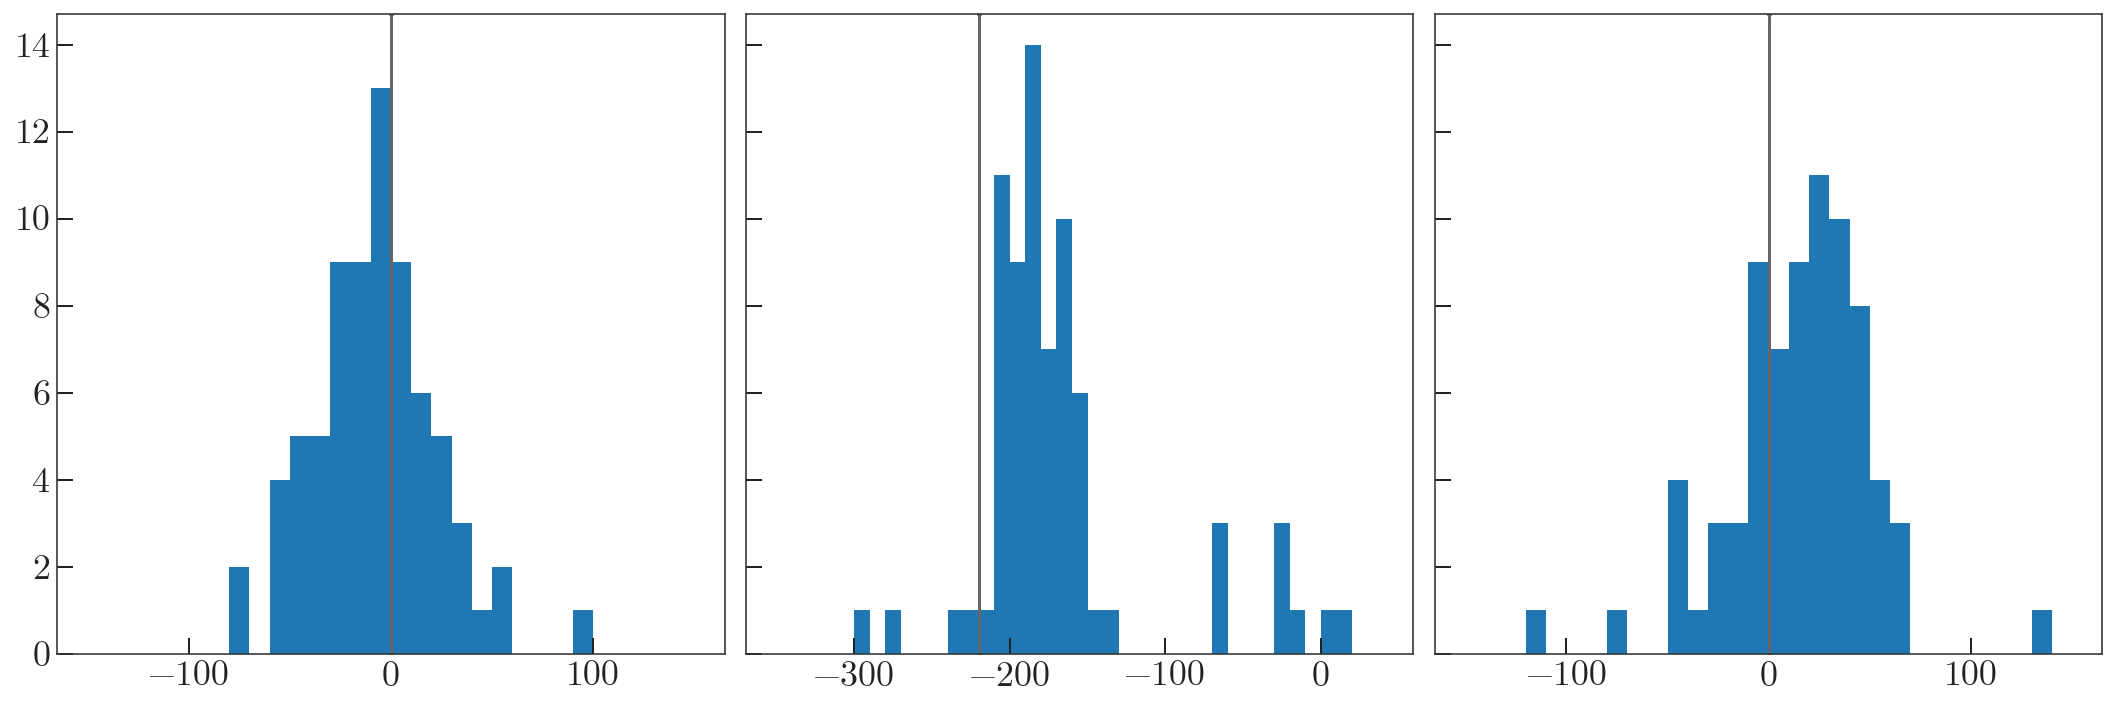

In [186]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for i in range(3):
    if i == 1:
        bins = np.arange(-350+0.1, 50, 10.)
        axes[i].axvline(-220)
    else:
        bins = np.arange(-150, 150+0.1, 10.)
        axes[i].axvline(0)
    axes[i].hist(med_vcyl[i], bins=bins)
    
fig.tight_layout()

(110, 180)

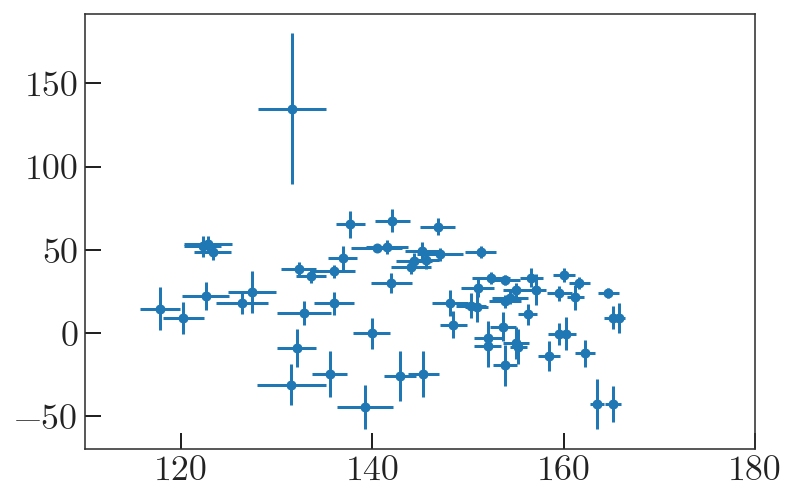

In [24]:
plt.errorbar(med_cyl[1][vtot_mask], 
             med_vcyl[2][vtot_mask],
             xerr=std_cyl[1][vtot_mask],
             yerr=std_vcyl[2][vtot_mask], 
             marker='o', ls='none')

plt.xlim(110, 180)
# plt.ylim(-15, 5)

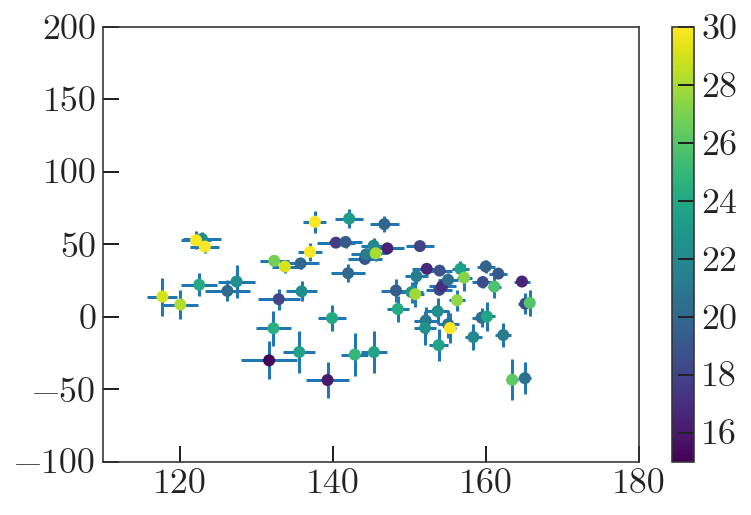

In [255]:
plt.errorbar(med_cyl[1][vtot_mask], 
             med_vcyl[2][vtot_mask],
             xerr=std_cyl[1][vtot_mask],
             yerr=std_vcyl[2][vtot_mask], 
             marker='', ls='none')

plt.scatter(med_cyl[1][vtot_mask], 
            med_vcyl[2][vtot_mask],
            c=med_cyl[0][vtot_mask], 
            vmin=15, vmax=30, zorder=100)

plt.xlim(110, 180)
plt.ylim(-100, 200)

plt.colorbar()

---

First do XD to get initial guess

In [190]:
from xdgmm import XDGMM

In [191]:
gmm = XDGMM(n_components=3)

In [193]:
cov_cyl = np.array([std_vcyl.T[i] * np.eye(3) 
                    for i in range(vcyl.shape[0])])

In [221]:
_ = gmm.fit(med_vcyl.T[vtot_mask], cov_cyl[vtot_mask])

/Users/adrian/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/adrian/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/adrian/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/adrian/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecatio

In [222]:
gmm.mu

array([[ -47.85725164, -224.9501286 ,  -14.37657288],
       [  -8.7369654 , -177.98987329,   34.24677191],
       [   2.96038559, -180.97014696,    1.64832658]])

In [223]:
from astroML.plotting.tools import draw_ellipse

(-150, 150)

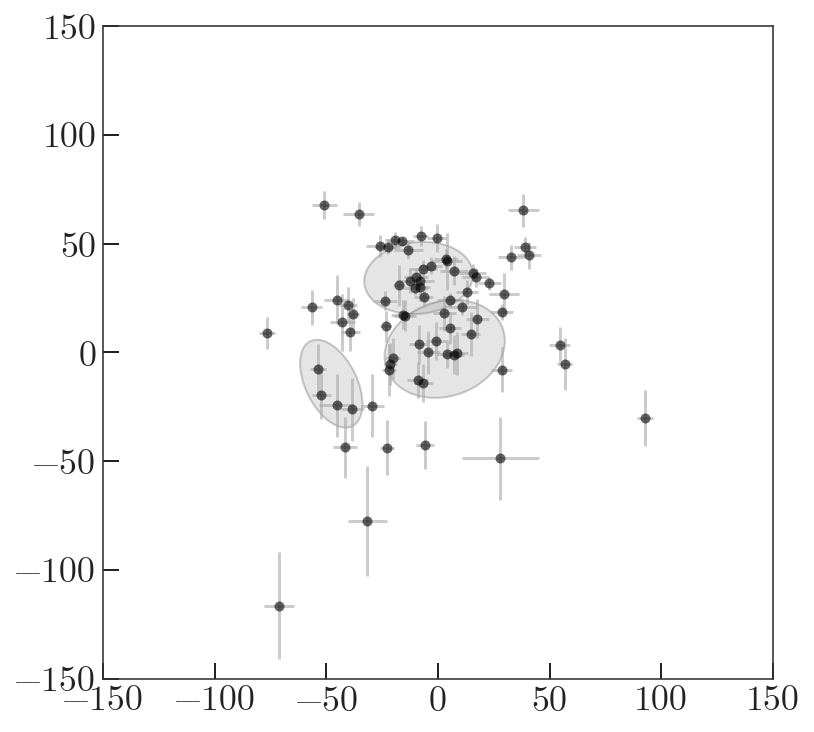

In [226]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

for i in range(gmm.n_components):
    mu = gmm.mu[i][[0, 2]]
    V = gmm.V[i].copy()
    V = np.delete(V, 1, axis=0)
    V = np.delete(V, 1, axis=1)
    
    draw_ellipse(mu, V, scales=[1], ax=ax,
                 ec='k', fc='gray', alpha=0.2)
    
ax.errorbar(med_vcyl[0], 
            med_vcyl[2],
            xerr=std_vcyl[0],
            yerr=std_vcyl[2],
            **style)
    
ax.set_xlim(-150, 150)
ax.set_ylim(-150, 150)
# ax.set_ylim(-400, 0)